# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 9: *SuperpixelsSLIC*
Perform the simple linear interactive clustering 
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadL, createImageF, createImageRGB, imageReadRGB, \
                         plotImageRGB, createImage2I, createImageUV
from ConvolutionUtilities import createSobelKernel, applyKernelMA
from PrintUtilities import printProgress
                         
# Math and iteration
from math import sqrt
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageName = Input image name
    numPixels = Number of super pixels per row
    m = Proximity constant
    numIter =  Number of iterations

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter9/Input/")
imageName = "fish.png"
numPixels = 700
m = 10.0
numIter = 10

FLT_MAX = sys.float_info.max

### Show input image

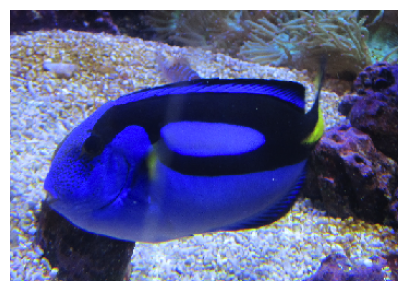

In [3]:
inputImage, width, height = imageReadRGB(pathToDir+imageName)
inputImageL, _, _ = imageReadL(pathToDir+imageName)
plotImageRGB(inputImage)

### Compute gradient

In [4]:
# Gradient used to determine initial positions
sobelX, sobelY = createSobelKernel(3)
normalizeMagnitude = False
gradient, _, _, _ = applyKernelMA(inputImageL, sobelX, sobelY, normalizeMagnitude)

### Determine initial regions

In [5]:
# Determine the number of regions in horizontal and vertical
regionSide = int(sqrt(width *  height / numPixels)) 
if regionSide % 2 == 0: regionSide -= 1
halfRegionSide = (regionSide - 1.0) / 2.0
regW, regH = 1 + int(width / regionSide), 1 + int(height / regionSide)

# Image to store the region colour and other image for position
regionColour = createImageF(regW, regH, 3)
regionPos = createImageUV(regW, regH)

# Initial regions
regionsID = createImage2I(width, height)
for x,y in itertools.product(range(0, regW), range(0, regH)):
    ry, rx = y * regionSide, x * regionSide    
    # Position
    py, px = int(ry + halfRegionSide), int(rx + halfRegionSide)
    regionPos[y,x] = [py, px]
    minGradient = FLT_MAX
    for wx,wy in itertools.product(range(px-1, px+2), range(py-1, py+2)):
        if (wy < height and wx < width):
            if gradient[wy,wx] < minGradient:
                minGradient = gradient[wy,wx] 
                regionPos[y,x] = [wy, wx]
    # Colour
    colors = [0, 0, 0]
    npts = 0.0
    for wx,wy in itertools.product(range(rx, rx + regionSide),                       \
                                   range(ry, ry + regionSide)):
        if wy>=0 and wy<height and wx>=0 and wx<width:
            if (wy < height and wx < width):
                regionsID[wy, wx] = [y, x]
                colors += inputImage[wy,wx]
                npts += 1
            if npts > 0: 
                regionColour[y,x] = [int(colors[0] / npts),                          \
                                     int(colors[1] / npts), int(colors[2] / npts)] 

### Find regions

In [6]:
# Modify regions
for itr in range(0, numIter):
    printProgress(itr, numIter)
    # Values for new regions
    newRegionColour = createImageF(regW, regH,3)
    newRegionPos = createImageUV(regW, regH)    
    newRegionSize = createImageF(regW, regH)   
    
    # Per pixel
    for x,y in itertools.product(range(0, width), range(0, height)):
        ry, rx = regionsID[y,x]  
        colour = [float(inputImage[y,x][0]), float(inputImage[y,x][1]), float(inputImage[y,x][2])]
        minD = [FLT_MAX, ry, rx]
        for wx,wy in itertools.product(range(rx-2, rx + 3), range(ry-2, ry + 3)):
            if wy>=0 and wy<regH and wx>=0 and wx<regW:    
                ds = sqrt((regionPos[wy,wx][0] - y)**2 + (regionPos[wy,wx][1] - x)**2)
                dc = sqrt((float(regionColour[wy,wx][0]) - colour[0])**2 + (float(regionColour[wy,wx][1]) - colour[1])**2  +    \
                          (float(regionColour[wy,wx][2]) - colour[2])**2)
                D = dc/255.0 + (m / regionSide) * ds
                if D < minD[0]: 
                    minD = [D, wy, wx]
        [_, minY, minX] = minD
        newRegionColour[minY, minX] += colour
        newRegionPos[minY, minX] += [y,x]
        newRegionSize[minY, minX] += 1
        regionsID[y, x] = [minY, minX] 
           
    # Update regions   
    for x,y in itertools.product(range(0, regW), range(0, regH)):
        if newRegionSize[y,x] > 0:
            regionPos[y,x] = newRegionPos[y,x] / newRegionSize[y,x]
            regionColour[y,x] = newRegionColour[y,x] / newRegionSize[y,x]

0 / 10  .. 1 / 10  .. 2 / 10  .. 3 / 10  .. 4 / 10  .. 5 / 10  .. 6 / 10  .. 7 / 10  .. 8 / 10  .. 9 / 10  .. 

### Show regions

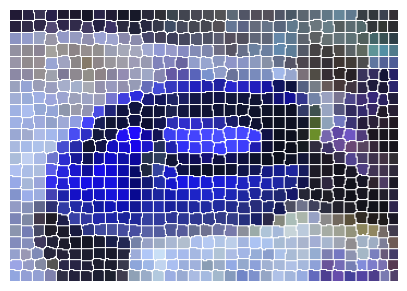

In [7]:
resultRegions = createImageRGB(width, height)
for x,y in itertools.product(range(0, width), range(0, height)):
    border = False
    for wx,wy in itertools.product(range(x, x+2), range(y, y+2)):
        if wy>=0 and wy<height and wx>=0 and wx<width:
            if regionsID[y, x, 0] != regionsID[wy, wx, 0] or regionsID[y, x, 1] != regionsID[wy, wx, 1]: 
                border = True
    if border:
        resultRegions[y,x] = [255, 255, 255]    
    else:
        [h, w] = regionsID[y,x];
        resultRegions[y,x] =  regionColour[h, w]

plotImageRGB(resultRegions)
